In [1]:
from mingpt.utils import set_seed
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from torch.utils.data import Dataset, DataLoader
from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN
import time

import routegym.env
import networkx as nx

sparsity = 0.54


/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


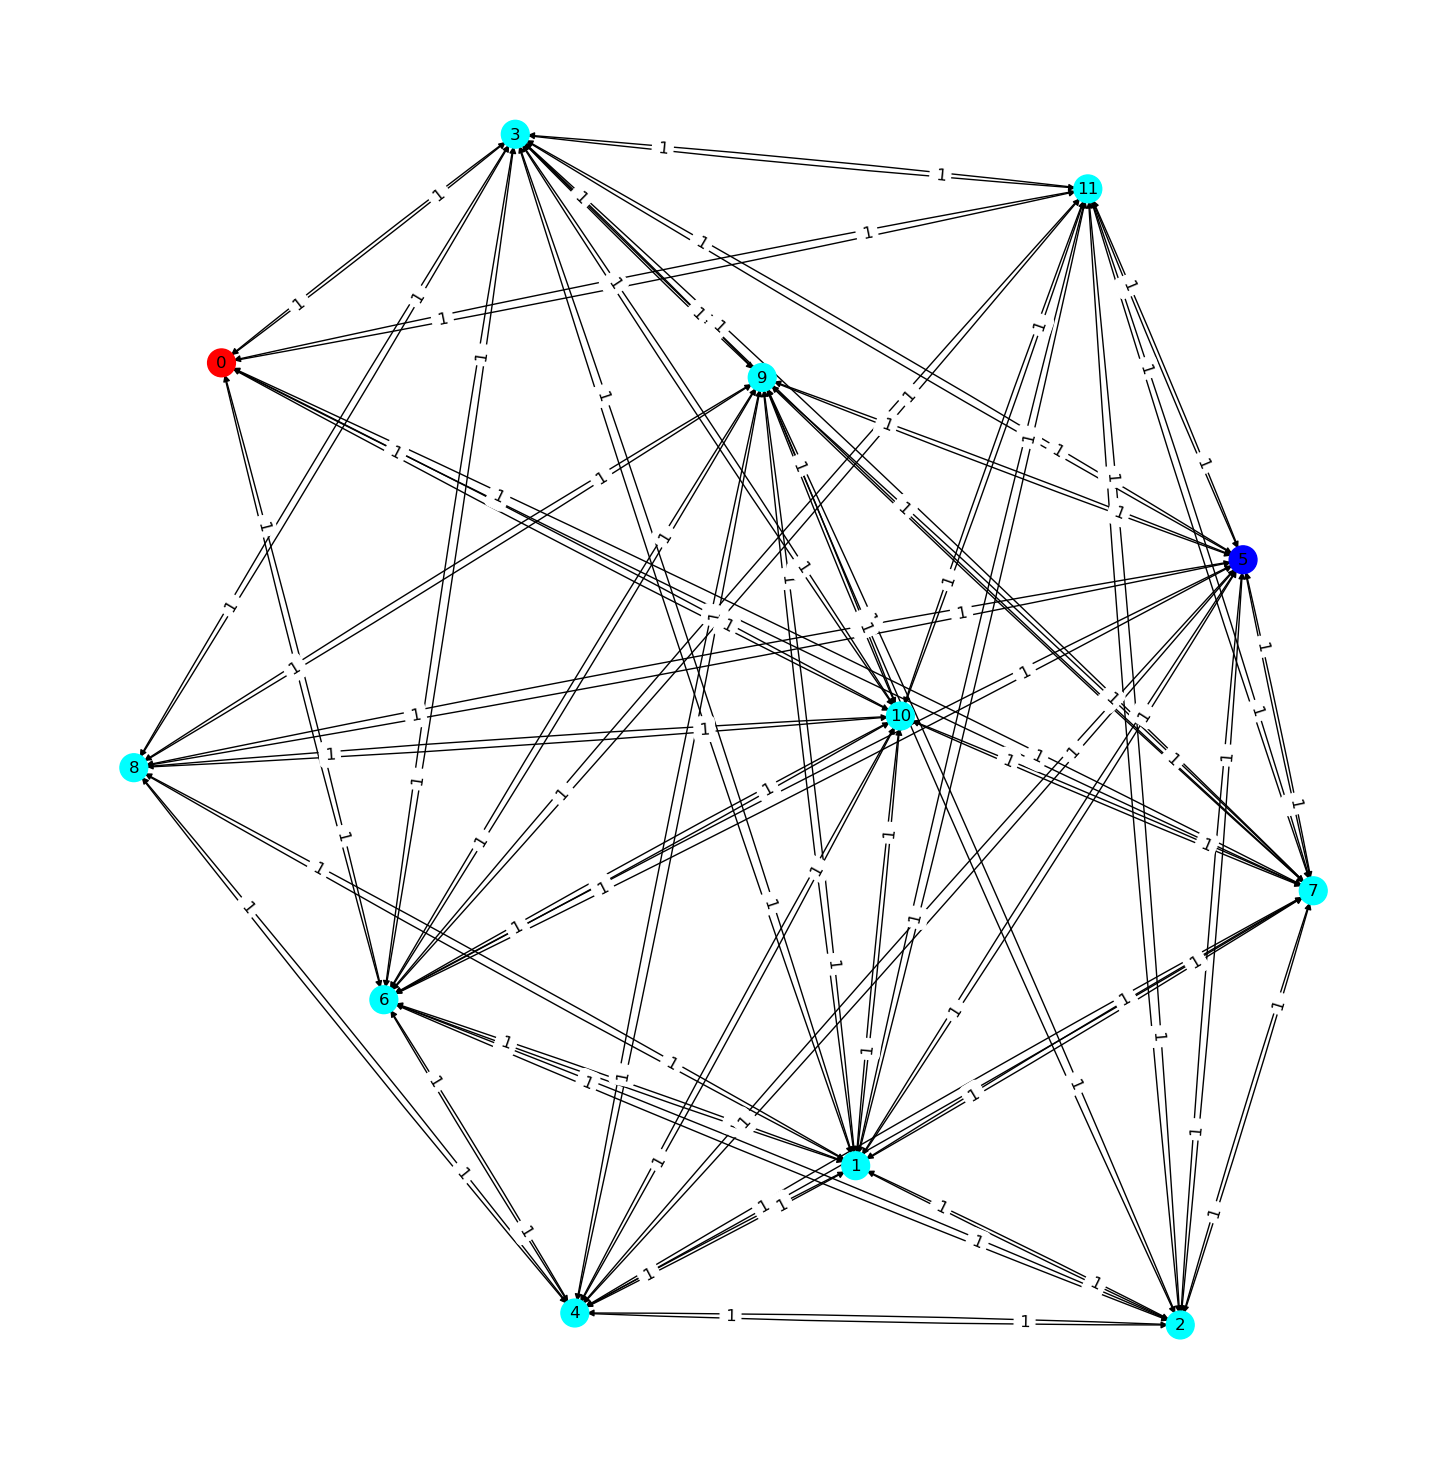

[[0 0 0 1 0 0 1 1 0 0 1 1]
 [0 0 1 1 0 1 0 1 1 1 0 0]
 [0 1 0 0 1 0 0 1 0 1 0 1]
 [1 1 0 0 0 1 0 1 1 1 0 0]
 [0 1 1 0 0 1 1 1 1 1 0 0]
 [0 0 1 0 1 0 1 0 0 1 0 1]
 [1 1 1 1 0 1 0 0 0 1 0 1]
 [0 0 1 1 0 1 0 0 0 1 1 1]
 [0 1 0 0 1 1 0 0 0 1 1 0]
 [0 1 0 1 1 0 0 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 1 1 0 0]
 [0 1 0 1 0 1 0 0 0 0 1 0]]
[[-1 -1 -1  1 -1 -1  1  1 -1 -1  1  1]
 [-1 -1  1  1  1  1  1  1  1  1  1  1]
 [-1  1 -1 -1  1  1  1  1 -1  1 -1  1]
 [ 1  1 -1 -1 -1  1  1  1  1  1  1  1]
 [-1  1  1 -1 -1  1  1  1  1  1  1 -1]
 [-1  1  1  1  1 -1  1  1  1  1 -1  1]
 [ 1  1  1  1  1  1 -1 -1 -1  1  1  1]
 [ 1  1  1  1  1  1 -1 -1 -1  1  1  1]
 [-1  1 -1  1  1  1 -1 -1 -1  1  1 -1]
 [-1  1  1  1  1  1  1  1  1 -1  1 -1]
 [ 1  1 -1  1  1 -1  1  1  1  1 -1  1]
 [ 1  1  1  1 -1  1  1  1 -1 -1  1 -1]]


In [2]:
node_number = 12

env = None
while env is None:
    try:
        A = sp.sparse.random(node_number, node_number, density=0.5, format='csr')
        A.data[:] = 1
        A = A.todense()
        A = np.ma.array(A, mask=np.eye(node_number)).filled(fill_value=0).astype(int)
        print("sparsity = %.2f" % (1 - np.sum(A)/A.size))
        G = nx.from_numpy_array(A)
        env = routegym.env.ShortestRouteEnv(G, 0, 5, random_weights=(1,10))
    except:
        pass
env.render()
print(A)
print(env.graph.adj_mat)
# print(env.get_dijkstra())

In [3]:
for _ in range(30):
    env.reset()

In [4]:
rew = 0
position = 0
env.reset()
done = False
print("Position: {", end='')
while not done:
    action = np.random.choice(np.arange(0, env.graph.adj_mat.shape[0]))
    position, reward, done, _ = env.step(action)
    # env.render()
    print("%d, " % position, end='')
    rew += reward
print("}\n")
print("Final reward: %.2f" % rew)
env.reset()
done

Position: {10, 9, 7, 3, 8, 8, 8, 9, 4, 5, }

Final reward: -9.00


True

In [5]:
env.reset()

num_steps = 10_000

def create_dataset():
    obss = []
    actions = []
    returns = [0]
    done_idxs = []
    stepwise_returns = []

    # simulate to create trajectories
    transitions_per_buffer = np.zeros(50, dtype=int)
    num_trajectories = 0
    while len(obss) < num_steps:
        done = False
        for _ in range(10):
            ac = np.random.choice(np.arange(0, env.graph.adj_mat.shape[0]))
            state, reward, done, _ = env.step(ac)
            obss += [state]
            actions += [ac]
            stepwise_returns += [reward]
            returns[-1] += reward
        # done = False
        env.reset()
        done_idxs += [len(obss)]
        returns += [0]

    actions = np.array(actions)
    returns = np.array(returns)
    stepwise_returns = np.array(stepwise_returns)
    done_idxs = np.array(done_idxs)

    # create reward-to-go dataset
    start_index = 0
    rtg = np.zeros_like(stepwise_returns)
    for i in done_idxs:
        i = int(i)
        curr_traj_returns = stepwise_returns[start_index:i]
        for j in range(i-1, start_index-1, -1): # start from i-1
            rtg_j = curr_traj_returns[j-start_index:i-start_index]
            rtg[j] = sum(rtg_j)
        start_index = i
    print('max rtg is %d' % max(rtg))

    # create timestep dataset
    start_index = 0
    timesteps = np.zeros(len(actions)+1, dtype=int)
    for i in done_idxs:
        i = int(i)
        timesteps[start_index:i+1] = np.arange(i+1 - start_index)
        start_index = i+1
    print('max timesteps is %d' % max(timesteps))

    return obss, actions, returns, done_idxs, rtg, timesteps

In [58]:
obss, actions, returns, done_idxs, rtgs, timesteps = create_dataset()
print(returns[:-1].max())
timesteps[25:41]

max rtg is 0
max timesteps is 10
-7.0


array([4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [62]:
(obss[0:10], actions[0:10], rtgs[0:10])

([5, 5, 5, 5, 8, 8, 4, 1, 11, 5],
 array([ 5, 10,  5,  0,  8,  2,  4,  1, 11,  5]),
 array([-8., -8., -7., -6., -5., -4., -3., -2., -1.,  0.]))

In [7]:
class StateActionReturnDataset(Dataset):

    @staticmethod
    def get_default_config():
        C = CN()
        C.block_size = 10 * 3
        return C

    def __init__(self, data, block_size, actions, done_idxs, rtgs, timesteps):
        self.block_size = block_size
        self.vocab_size = max(actions) + 1
        self.data = data
        self.actions = actions
        self.done_idxs = done_idxs
        self.rtgs = rtgs
        self.timesteps = timesteps

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        block_size = self.block_size // 3
        done_idx = idx + block_size
        for i in self.done_idxs:
            if i > idx: # first done_idx is greater than idx
                done_idx = min(int(i), done_idx)
                break
        idx = done_idx - block_size
        states = torch.tensor(np.array(self.data[idx:done_idx]), dtype=torch.float32).reshape(block_size, -1) # (block_size, state_dim)
        actions = torch.tensor(self.actions[idx:done_idx], dtype=torch.long).unsqueeze(1) # (block_size, 1)
        rtgs = torch.tensor(self.rtgs[idx:done_idx], dtype=torch.float32).unsqueeze(1) # (block_size, 1)
        timesteps = torch.tensor(self.timesteps[idx:idx+1], dtype=torch.int64).unsqueeze(1) # (block_size, 1)

        return states, actions, rtgs, timesteps

In [8]:
C = CN()

# system
C.system = CN()
C.system.seed = 3407
C.system.work_dir = './out/decgpt'

# data
C.data = StateActionReturnDataset.get_default_config()

# model 
C.model = GPT.get_default_config()
C.model.model_type = 'gpt-mini'

# trainer
C.trainer = Trainer.get_default_config()
C.trainer.learning_rate = 5e-4
C.trainer.max_epochs = 200
C.trainer.num_workers = 4

In [9]:
train_dataset = StateActionReturnDataset(obss, 10 * 3, actions, done_idxs, rtgs, timesteps)


In [10]:
C.model.vocab_size = train_dataset.vocab_size
C.model.block_size = train_dataset.block_size
C.model.max_timestep = max(timesteps)
C.model.max_timestep

10

In [11]:
model = GPT(C.model)

number of parameters: 2.68M


In [45]:
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True, batch_size=4)

In [46]:
for _ in range(121):
    x, y, r, t = next(iter(loader))

In [53]:
x, y, r, t = next(iter(loader))

In [55]:
x[0], y[0], r[0]

(tensor([[ 6.],
         [ 6.],
         [ 6.],
         [11.],
         [ 0.],
         [ 6.],
         [ 2.],
         [ 2.],
         [11.],
         [ 0.]]),
 tensor([[ 6],
         [ 6],
         [ 6],
         [11],
         [ 0],
         [ 6],
         [ 2],
         [ 3],
         [11],
         [ 0]]),
 tensor([[-10.],
         [ -9.],
         [ -8.],
         [ -7.],
         [ -6.],
         [ -5.],
         [ -4.],
         [ -3.],
         [ -2.],
         [ -1.]]))

In [15]:
model(x, y, y, r, t)

(tensor([[[ 0.0736,  0.0316, -0.1089, -0.0549,  0.3232,  0.7894, -0.1563,
            0.1290,  0.0603, -0.1360, -0.3495,  0.4266],
          [ 0.2160,  0.1281, -0.1993,  0.0266,  0.1320,  0.7183, -0.0289,
           -0.2951,  0.1871, -0.4148,  0.0074,  0.0616],
          [-0.1677,  0.2326,  0.4625, -0.1965,  0.0891,  0.1104,  0.4034,
            0.0988,  0.1212,  0.0887, -0.1872,  0.2029],
          [-0.1770, -0.0397,  0.3414, -0.2838,  0.2202,  0.0371,  0.3085,
            0.0344,  0.0038,  0.3913, -0.3323,  0.1502],
          [-0.0979,  0.2785,  0.4882, -0.3607,  0.1793, -0.0735,  0.4606,
            0.1791, -0.0777,  0.1684, -0.2160,  0.2601],
          [ 0.0680,  0.0676,  0.4736, -0.0436,  0.0927, -0.1559,  0.5090,
            0.2682, -0.1397,  0.2746, -0.0853,  0.0229],
          [-0.1020, -0.0908,  0.2602, -0.4082, -0.0051, -0.0349,  0.3176,
            0.0059, -0.1731,  0.4258, -0.1606,  0.3116],
          [-0.1910,  0.1463,  0.3071, -0.2580,  0.0477, -0.2598,  0.2701,
         

In [16]:
trainer = Trainer(model, train_dataset, C.trainer)

running on device cuda


In [17]:
trainer.run()

/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 1.17480. lr 5.000000e-04:  96%|█████████▌| 150/156 [00:02<00:00, 69.28it/s]/home/icute/mambaforge/envs/dec-transformer-route/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
epoch 1 iter 155: train loss 1.17480. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 63.74it/s]
epoch 2 iter 155: train loss 0.89313. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 67.64it/s]
epoch 3 iter 155: train loss 1.71488. lr 5.000000e-04: 100%|██████████| 156/156 [00:02<00:00, 67.85it/s]
epoch 4 iter 155: train los

In [44]:
model.eval()
with torch.no_grad():
    done = True
    for i in range(10):
        # sample from the model
        state = torch.tensor(env.reset())
        state = state.type(torch.float32).to(trainer.device).unsqueeze(0).unsqueeze(0)
        rtgs = [10+1-2]
        # first state is from env, first rtg is target return, and first timestep is 0
        sampled_action = model.generate(state, 1, temperature=1.0, do_sample=True, actions=None, 
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=torch.zeros((1, 1, 1), dtype=torch.int64).to(trainer.device))

        j = 0
        all_states = state
        actions = []
        while True:
            if done:
                state, reward_sum, done = torch.tensor(env.reset()), 0, False
            action = sampled_action.cpu().numpy()[0, -1]
            actions += [sampled_action]
            state, reward, done, _ = env.step(action)
            reward_sum += reward
            j += 1

            if done:
                break

            state = torch.tensor(state).unsqueeze(0).unsqueeze(0).to(trainer.device)

            all_states = torch.cat([all_states, state], dim=0)

            rtgs += [rtgs[-1] - reward]
            print(rtgs[-1])
            # all_states has all previous states and rtgs has all revious rtgs (weill be cut to block_size in trainer.generate)
            # timestep is just the current timestep
            sampled_action = model.generate(all_states.unsqueeze(0), 1, temperature=1.0, do_sample=True, 
                            actions=torch.tensor(actions, dtype=torch.long).to(trainer.device).unsqueeze(-1).unsqueeze(0),
                            rtgs=torch.tensor(rtgs, dtype=torch.long).to(trainer.device).unsqueeze(0).unsqueeze(-1),
                            timesteps=(min(j, model.config.max_timestep) * torch.ones((1, 1, 1), dtype=torch.int64).to(trainer.device)))

8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
0.0
-1.0
-2.0
-3.0
-4.0
-5.0
-6.0
-7.0
-8.0
-9.0
-10.0
-11.0
-12.0
-13.0
-14.0
-15.0
-16.0
-17.0
-18.0
-19.0
-20.0
-21.0
-22.0
-23.0
-24.0
-25.0
-26.0
-27.0
-28.0
-29.0
-30.0
-31.0
-32.0
-33.0
-34.0
-35.0
-36.0
-37.0
-38.0
-39.0
-40.0
-41.0
-42.0
-43.0
-44.0
-45.0
-46.0
-47.0
-48.0
-49.0
-50.0
-51.0
-52.0
-53.0
-54.0
-55.0
-56.0
-57.0
-58.0
-59.0
-60.0
-61.0
-62.0
-63.0
-64.0
-65.0
-66.0
-67.0
-68.0
-69.0
-70.0
-71.0
-72.0
-73.0
-74.0
-75.0
-76.0
-77.0
-78.0
-79.0
-80.0
-81.0
-82.0
-83.0
-84.0
-85.0
-86.0
-87.0
-88.0
-89.0
-90.0
-91.0
-92.0
-93.0
-94.0
-95.0
-96.0
-97.0
-98.0
-99.0
-100.0
-101.0
-102.0
-103.0
-104.0
-105.0
-106.0
-107.0
-108.0
-109.0
-110.0
-111.0
-112.0
-113.0
-114.0
-115.0
-116.0
-117.0
-118.0
-119.0
-120.0
-121.0
-122.0
-123.0
-124.0
-125.0
-126.0
-127.0
-128.0
-129.0
-130.0
-131.0
-132.0
-133.0
-134.0
-135.0
-136.0
-137.0
-138.0
-139.0
-140.0
-141.0
-142.0
-143.0
-144.0
-145.0
-146.0
-147.0
-148.0
-149.0
-150.0
-151.0
-152.0
-153.0
-

KeyboardInterrupt: 